## imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

Using device: cpu


## Loading required data and transformations

In [3]:
df = pd.read_csv('cleaned_data/updated_over_by_over_data_set.csv')

df['season'] = df['season'].astype(str)
df['season_year'] = df['season'].apply(lambda x: int(x.split('/')[0]))
max_year = 2024
df['season_weight'] = np.exp(-0.1 * (max_year - df['season_year']))

# Encode teams using LabelEncoder + Embedding
team_encoder = LabelEncoder()
df['batting_team'] = team_encoder.fit_transform(df['batting_team'])
df['bowling_team'] = team_encoder.fit_transform(df['bowling_team'])

# Numerical features
numerical_features = ['over', 'run_rate', 'req_runrate', 'target_left', 'season_weight']
scaler = StandardScaler()
numerical_data = scaler.fit_transform(df[numerical_features])

# Step 3: Split the dataset into train and test (by match_id)
match_ids = df['match_id'].unique()
train_match_ids, test_match_ids = train_test_split(match_ids, test_size=0.2, random_state=42)
train_df = df[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
test_df = df[df['match_id'].isin(test_match_ids)].reset_index(drop=True)

# Prepare numerical data for train and test sets
train_numerical_data = scaler.transform(train_df[numerical_features])
test_numerical_data = scaler.transform(test_df[numerical_features])

# Create index mappings for train and test DataFrames
train_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(train_df.index)}
test_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(test_df.index)}


## Training Model

In [4]:
class IPLDataset(Dataset):
    def __init__(self, df, numerical_data, index_map):
        self.df = df
        self.numerical_data = numerical_data
        self.index_map = index_map
        self.matches = []
        for match_id in df['match_id'].unique():
            for inning in [1, 2]:
                match_inning = df[(df['match_id'] == match_id) & (df['inning'] == inning)]
                if len(match_inning) > 1:
                    self.matches.append(match_inning)

    def __len__(self):
        return sum(len(match) - 1 for match in self.matches)

    def __getitem__(self, idx):
        cum_idx = 0
        for match in self.matches:
            match_len = len(match) - 1
            if cum_idx + match_len > idx:
                over_idx = idx - cum_idx
                current_over = match.iloc[:over_idx + 1]
                next_over = match.iloc[over_idx + 1]
                break
            cum_idx += match_len

        # Map the original index to the new index in the split DataFrame
        original_idx = current_over.index[-1]
        mapped_idx = self.index_map[original_idx]

        team1 = torch.tensor(current_over['batting_team'].values[-1], dtype=torch.long)
        team2 = torch.tensor(current_over['bowling_team'].values[-1], dtype=torch.long)
        num_data = torch.tensor(self.numerical_data[mapped_idx], dtype=torch.float32)
        runs = torch.tensor(next_over['total_runs'], dtype=torch.float32)
        wickets = torch.tensor(next_over['is_wicket'], dtype=torch.float32)
        return team1, team2, num_data, runs, wickets

In [5]:
train_dataset = IPLDataset(train_df, train_numerical_data, train_index_map)
test_dataset = IPLDataset(test_df, test_numerical_data, test_index_map)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


## Model Architecture

In [6]:
# Step 5: Define the model architecture
class IPLModel(nn.Module):
    def __init__(self, num_teams, embedding_dim, numerical_dim, hidden_dim):
        super(IPLModel, self).__init__()
        self.team1_embedding = nn.Embedding(num_teams, embedding_dim)
        self.team2_embedding = nn.Embedding(num_teams, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * 2 + numerical_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim // 2, batch_first=True)
        self.fc2 = nn.Linear(hidden_dim // 2, 8)
        self.runs_output = nn.Linear(8, 1)
        self.wickets_output = nn.Linear(8, 1)

    def forward(self, team1, team2, num_data):
        team1_embed = self.team1_embedding(team1).squeeze(1)
        team2_embed = self.team2_embedding(team2).squeeze(1)
        x = torch.cat((team1_embed, team2_embed, num_data), dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        x = self.fc2(lstm_out)
        x = self.relu(x)
        runs = self.runs_output(x).squeeze()
        wickets = self.wickets_output(x).squeeze()
        wickets = self.relu(wickets)
        return runs, wickets

## Training and Validation Loop

/home/kalyan-neeraj/Desktop/Smai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/10:
Train Loss: 28.0482, Test Loss: 21.0750
Train Runs MAE: 4.0717, Test Runs MAE: 3.6037
Train Wickets MAE: 0.3160, Test Wickets MAE: 0.3097
Best model saved with Test Loss: 21.0750
Epoch 2/10:
Train Loss: 21.1689, Test Loss: 20.6477
Train Runs MAE: 3.6113, Test Runs MAE: 3.5632
Train Wickets MAE: 0.3128, Test Wickets MAE: 0.3097
Best model saved with Test Loss: 20.6477
Epoch 3/10:
Train Loss: 21.0211, Test Loss: 20.6036
Train Runs MAE: 3.5999, Test Runs MAE: 3.6027
Train Wickets MAE: 0.3127, Test Wickets MAE: 0.3097
Best model saved with Test Loss: 20.6036
Epoch 4/10:
Train Loss: 20.9386, Test Loss: 20.5642
Train Runs MAE: 3.5917, Test Runs MAE: 3.5822
Train Wickets MAE: 0.3128, Test Wickets MAE: 0.3097
Best model saved with Test Loss: 20.5642
Epoch 5/10:
Train Loss: 20.8852, Test Loss: 20.4474
Train Runs MAE: 3.5880, Test Runs MAE: 3.5647
Train Wickets MAE: 0.3128, Test Wickets MAE: 0.3097
Best model saved with Test Loss: 20.4474
Epoch 6/10:
Train Loss: 20.8710, Test Loss: 2

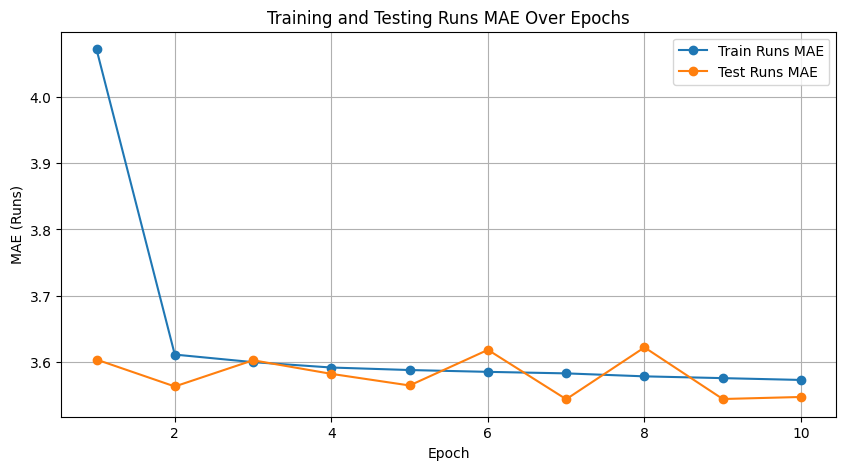

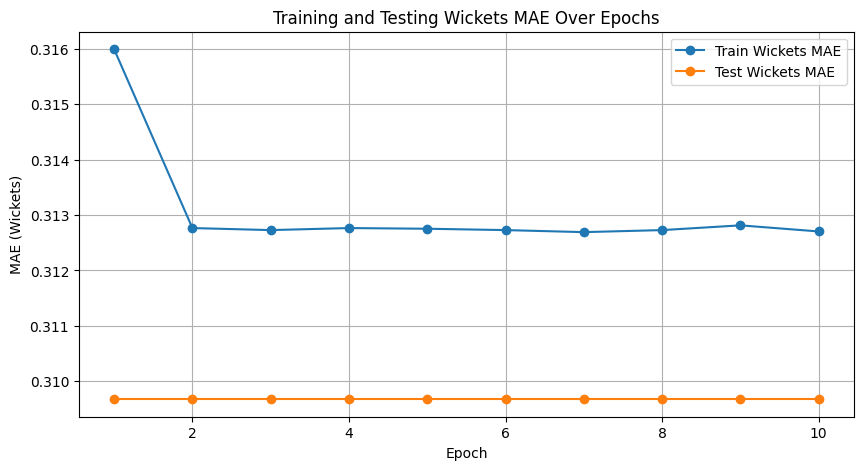

Plots saved as 'loss_over_epochs.png', 'runs_mae_over_epochs.png', and 'wickets_mae_over_epochs.png'


In [7]:
num_teams = len(team_encoder.classes_)
model = IPLModel(num_teams=num_teams, embedding_dim=10, numerical_dim=len(numerical_features), hidden_dim=32)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Lists to store metrics for plotting
train_losses = []
test_losses = []
train_runs_mae = []
test_runs_mae = []
train_wickets_mae = []
test_wickets_mae = []

num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_r_mae = 0
    train_w_mae = 0
    for team1, team2, num_data, runs, wickets in train_loader:
        team1, team2, num_data = team1.to(device), team2.to(device), num_data.to(device)
        runs, wickets = runs.to(device), wickets.to(device)

        optimizer.zero_grad()
        pred_runs, pred_wickets = model(team1, team2, num_data)
        loss_runs = criterion(pred_runs, runs)
        loss_wickets = criterion(pred_wickets, wickets)
        loss = loss_runs + loss_wickets
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_r_mae += torch.mean(torch.abs(pred_runs - runs)).item()
        train_w_mae += torch.mean(torch.abs(pred_wickets - wickets)).item()

    train_losses.append(train_loss / len(train_loader))
    train_runs_mae.append(train_r_mae / len(train_loader))
    train_wickets_mae.append(train_w_mae / len(train_loader))

    # Testing phase
    model.eval()
    test_loss = 0
    test_r_mae = 0
    test_w_mae = 0
    with torch.no_grad():
        for team1, team2, num_data, runs, wickets in test_loader:
            team1, team2, num_data = team1.to(device), team2.to(device), num_data.to(device)
            runs, wickets = runs.to(device), wickets.to(device)

            pred_runs, pred_wickets = model(team1, team2, num_data)
            loss_runs = criterion(pred_runs, runs)
            loss_wickets = criterion(pred_wickets, wickets)
            loss = loss_runs + loss_wickets
            test_loss += loss.item()
            test_r_mae += torch.mean(torch.abs(pred_runs - runs)).item()
            test_w_mae += torch.mean(torch.abs(pred_wickets - wickets)).item()

    test_losses.append(test_loss / len(test_loader))
    test_runs_mae.append(test_r_mae / len(test_loader))
    test_wickets_mae.append(test_w_mae / len(test_loader))

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    print(f"Train Runs MAE: {train_runs_mae[-1]:.4f}, Test Runs MAE: {test_runs_mae[-1]:.4f}")
    print(f"Train Wickets MAE: {train_wickets_mae[-1]:.4f}, Test Wickets MAE: {test_wickets_mae[-1]:.4f}")

    best_test_loss = float("inf")
    # Save best model
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        torch.save(model.state_dict(), 'best_ipl_model.pth')
        print(f"Best model saved with Test Loss: {best_test_loss:.4f}")
    if device.type == 'cuda':
        print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
epochs = range(1, num_epochs + 1)
# Plot 1: Training vs Testing Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('loss_over_epochs.png')
plt.close()

# Plot 2: Training vs Testing Runs MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_runs_mae, label='Train Runs MAE', marker='o')
plt.plot(epochs, test_runs_mae, label='Test Runs MAE', marker='o')
plt.title('Training and Testing Runs MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (Runs)')
plt.legend()
plt.grid(True)
plt.savefig('runs_mae_over_epochs.png')
plt.show()
plt.close()

# Plot 3: Training vs Testing Wickets MAE
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_wickets_mae, label='Train Wickets MAE', marker='o')
plt.plot(epochs, test_wickets_mae, label='Test Wickets MAE', marker='o')
plt.title('Training and Testing Wickets MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (Wickets)')
plt.legend()
plt.grid(True)
plt.savefig('wickets_mae_over_epochs.png')
plt.show()
plt.close()

print("Plots saved as 'loss_over_epochs.png', 'runs_mae_over_epochs.png', and 'wickets_mae_over_epochs.png'")

## Evaluation and Prediction

In [10]:
# Step 9: Load the best model and show predictions
print("\n📥 Loading best model for evaluation...")
model.load_state_dict(torch.load('best_ipl_model.pth'))
model.eval()

print("\n🎯 Actual vs Predicted on Test Set (first 10 samples):")
num_samples_to_show = 10
shown = 0

with torch.no_grad():
    for team1, team2, num_data, runs, wickets in test_loader:
        team1, team2, num_data = team1.to(device), team2.to(device), num_data.to(device)
        runs, wickets = runs.to(device), wickets.to(device)

        pred_runs, pred_wickets = model(team1, team2, num_data)

        for i in range(len(runs)):
            actual_runs = runs[i].item()
            predicted_runs = pred_runs[i].item()

            actual_wickets = wickets[i].item()
            predicted_wickets = pred_wickets[i].item()

            print(f"Sample {shown+1}:")
            print(f"  Runs    - Actual: {actual_runs:.2f}, Predicted: {predicted_runs:.2f}")
            print(f"  Wickets - Actual: {actual_wickets:.2f}, Predicted: {predicted_wickets:.2f} (rounded: {int(round(predicted_wickets))})\n")

            shown += 1
            if shown >= num_samples_to_show:
                break
        if shown >= num_samples_to_show:
            break



📥 Loading best model for evaluation...

🎯 Actual vs Predicted on Test Set (first 10 samples):
Sample 1:
  Runs    - Actual: 10.00, Predicted: 7.97
  Wickets - Actual: 0.00, Predicted: 0.00 (rounded: 0)

Sample 2:
  Runs    - Actual: 0.00, Predicted: 8.07
  Wickets - Actual: 1.00, Predicted: 0.00 (rounded: 0)

Sample 3:
  Runs    - Actual: 14.00, Predicted: 7.58
  Wickets - Actual: 1.00, Predicted: 0.00 (rounded: 0)

Sample 4:
  Runs    - Actual: 6.00, Predicted: 7.81
  Wickets - Actual: 0.00, Predicted: 0.00 (rounded: 0)

Sample 5:
  Runs    - Actual: 3.00, Predicted: 7.68
  Wickets - Actual: 0.00, Predicted: 0.00 (rounded: 0)

Sample 6:
  Runs    - Actual: 4.00, Predicted: 7.49
  Wickets - Actual: 1.00, Predicted: 0.00 (rounded: 0)

Sample 7:
  Runs    - Actual: 4.00, Predicted: 7.39
  Wickets - Actual: 1.00, Predicted: 0.00 (rounded: 0)

Sample 8:
  Runs    - Actual: 3.00, Predicted: 7.32
  Wickets - Actual: 0.00, Predicted: 0.00 (rounded: 0)

Sample 9:
  Runs    - Actual: 6.00, Pre

/home/kalyan-neeraj/Desktop/Smai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
